In [35]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [36]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)# 队列,先进先出

    def add(self, state, action, reward, next_state, done):  
        """将数据加入buffer"""
        self.buffer.append((state, action, reward, next_state, done)) #*还要加一个括号

    def sample(self, batch_size): 
        """从buffer中采样数据,数量为batch_size"""
        transitions =random.sample(self.buffer, batch_size)#* 随机采样batch_size个数据
        state, action, reward, next_state, done = zip(*transitions)# 解包
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  
        """目前buffer中数据的数量"""
        return len(self.buffer)

In [37]:
class Qnet(torch.nn.Module):#*
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__() #*
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [45]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.epsilon = epsilon
        self.action_dim = action_dim
        self.device = device
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(self.device)
        self.target_q_net = Qnet(state_dim, hidden_dim, action_dim).to(self.device)
        self.target_q_net.load_state_dict(self.q_net.state_dict()) #*
        self.gamma = gamma
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr = learning_rate) #*
        self.target_update = target_update
        self.count = 0
        

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            action = self.q_net(torch.tensor([state], dtype=torch.float).to(self.device)).argmax().item() #*
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) #*
        q_targets = rewards + max_next_q_values * self.gamma * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_targets , q_values)) #*
        self.optimizer.zero_grad() #*
        dqn_loss.backward()
        self.optimizer.step() #*

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict()) #*
        self.count += 1


In [60]:
hidden_dim = 128
learning_rate = 2e-3
gamma = 0.98
epsilon = 0.01
target_update = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_episodes = 500
minimal_size = 500
batch_size = 64
buffer_size = 10000

env_name = 'CartPole-v1'
env = gym.make(env_name)
replay_buffer = ReplayBuffer(buffer_size)
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0] #*
action_dim = env.action_space.n #*
agent = DQN(state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc = 'Interation {}'.format(i)) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            done = False
            state, _ = env.reset(seed = 0 if i + i_episode == 0 else None) #*
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action) #*
                done = terminated or truncated #*
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward #*
                if replay_buffer.size() > minimal_size: #*
                    b_s, b_a, b_r, next_state, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states' : b_s,
                        'actions' : b_a,
                        'next_states' : next_state,
                        'rewards' : b_r,
                        'dones' : b_d
                    } #*
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1) #*

Interation 9: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s, episode=500, return=394.200]


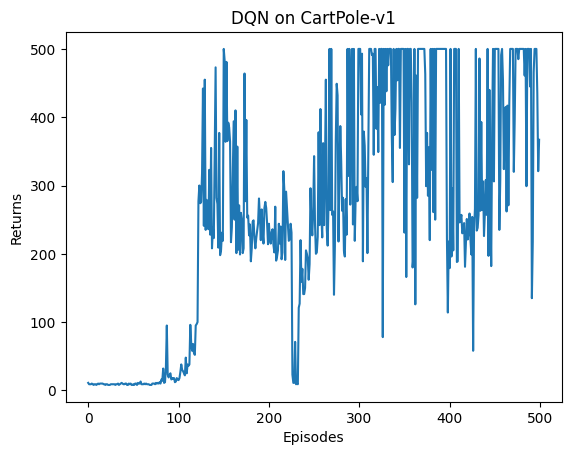

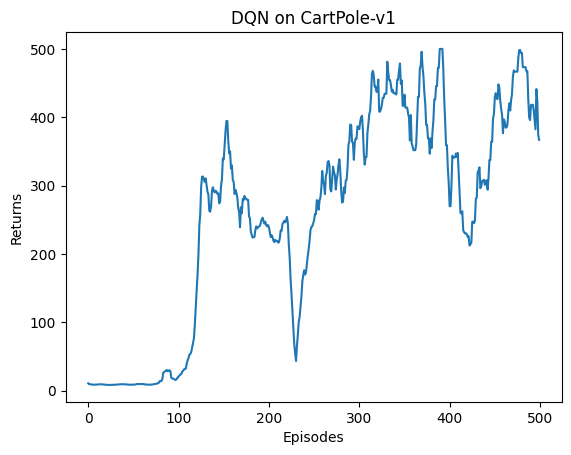

In [61]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()